## 基于mindspore实现二维线性回归

本实验将实现基于mindspore的二维线性回归，包括人造数据集、模型、损失函数和小批量随机梯度下降优化器。

### 1、实验目的
- 掌握如何使用MindSpore实现二维线性回归模型。
- 了解如何使用MindSpore定义小批量随机梯度下降优化器。
- 了解如何使用MindSpore计算梯度。


### 2、整体模型介绍
- 二维线性回归原理

在机器学习领域，线性回归模型记为：
$$y=w_0x_0+w_1x_1+\cdots+w_nx_n+b=[w_0 w_1 w_2 \cdots w_n][x_0 x_1 x_2 \cdots x_n]^T+b$$
可以统一形式为：
$$y=\sum_{i=0}^{n}w_ix_i+b=w^Tx+b$$


并且我们定义损失函数来度量模型一次预测的好坏，即预测值$\widehat y$和真实值y的误差，线性损失函数一般取$L=\frac{1}{2}(y-\widehat y)^2$，平方损失函数的几何意义是欧氏距离。

之后我们便可进行模型训练，采用梯度下降方法求模型参数w，使损失函数最小。

梯度下降法顺着当前点梯度反方向，按规定步长$\alpha$进行迭代搜索，对第i个模型参数进行如下更新：
$$w_{i+1}=w_i-\alpha \frac{\partial L(w)}{\partial (w_i)}$$
因为
$$\frac{\partial L(w)}{\partial (w_i)}=-\sum_{j=0}^{m}[y^{(j)}-\sum_{i=0}^{n}w_i x_i^{(j)}-b]*x_i^{(j)}$$
所以
$$w_{i+1}=w_i+\alpha [\sum_{j=0}^{m}(y^{(j)}-\sum_{i=0}^{n}w_i x_i^{(j)}-b)*x_i^{(j)}]$$
对每个模型参数迭代训练直到收敛即可。因此二维线性回归的自变量为两个，模型便为：
$$y=w_0x_0+w_1x_1+b=w^Tx+b$$
我们可定义二维线性回归模型Net、小批量随机梯度下降模型MBGD、整合整体运算过程的模型Trian实现二维线性回归。

- 定义一个二维线性回归模型Net，Net输入为样本$X$和对应的真实值y，根据公式$y=Xw+b=w_0x_0+w_1x_1+b$
计算出预测值$\widehat y$，然后根据$\widehat y$和y计算出均方损失并返回。
- 定义小批量随机梯度下降模型MBGD，输入计算好的梯度，完成权重更新操作。在每一步中，MBGD使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度，朝着减少损失的方向更新参数。
- 定义模型Train整合整个训练过程，完成预测值与真实值之间的损失计算、梯度计算、Net权重更新。

通过定义以上三个模型即可实现二维线性回归模型的训练。

### 3 实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=1.8；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore1.8 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore1.8 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore1.8 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|


### 4、数据处理
#### 4.1 数据准备
为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。任务是使用这个有限样本的数据集来恢复这个模型的参数。我们需要生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。 合成的数据集是一个矩阵$X∈R^{(1000×2)}$。我们使用线性模型参数$w =[2,-3.4]^T$、b=3.2和噪声项$\epsilon$生成数据集及其标签：
$y=Xw+b+\epsilon=w_0x_0+w_1x_1+b+\epsilon$

$\epsilon$可以视为模型预测和标签之间的观测误差，我们假设ϵ服从均值为0、标准差为0.01的正态分布。


random库实现了各种分布的伪随机数生成器;mindspore.numpy工具包提供了一系列类NumPy接口，用户可以使用类NumPy语法在MindSpore上进行模型的搭建;mindspore.ops提供对神经网络层的各种操作;pyplot是常用的绘图模块，能很方便让用户绘制 2D 图表;mindspore中的Tensor是张量，可放在gpu上加速。

In [95]:
%matplotlib inline
import random
import mindspore
import mindspore.numpy as mnp
import mindspore.ops as ops
from matplotlib import pyplot as plt
from mindspore import Tensor

In [96]:
import sys
sys.path.append('..')

In [97]:
def synthetic_data(w, b, num_examples):  
    print((num_examples, len(w)))
    X = ops.normal((num_examples, len(w)), Tensor(0, mindspore.int32), Tensor(1, mindspore.int32)) # 生成X
    y = ops.matmul(X, w) + b                                                                               # y = Xw + b
    y += ops.normal(y.shape, Tensor(0, mindspore.int32), Tensor(0.01, mindspore.float32))          # y = Xw + b + 噪声。
    return X, y.reshape((-1, 1))

mindspore.set_seed(1)
true_w = Tensor([2, -3.4], mindspore.float32)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)                                                    # 人造数据

(1000, 2)


#### 4.2 数据加载
数据features中的每一行都包含一个二维数据样本，真实值labels中的每一行都包含一维标签值（一个标量）

In [98]:
print('features:', features[0:4],'\nlabel:', labels[0:4])

features: [[ 0.15606569  0.30639967]
 [-0.5680398  -0.42438623]
 [-0.8062886  -0.20454668]
 [-1.2000442  -0.42873764]] 
label: [[3.487765 ]
 [4.4927335]
 [3.2986383]
 [3.2585537]]


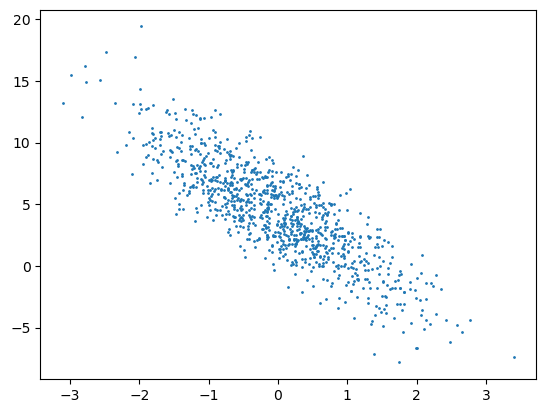

In [99]:
plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1);             # 画出第二个特征与真实值的散点图

因为训练模型时要对数据集遍历，每次迭代抽取一批样本来更新模型。因此我们需要定义函数data_iter(batch_size, features, labels)，用以打乱数据集中的样本并返回多批数据。

In [100]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)                                     # 打乱indices
    for i in range(0, num_examples, batch_size):
        batch_indices = Tensor(
            indices[i: min(i + batch_size, num_examples)])      # 最后一批数据大小可能小于batch_size
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):            # 一个batch的数据展示
    print(X, '\n', y)
    break

[[-0.70795256  0.00585518]
 [ 0.5678514   0.18228188]
 [ 1.0641294   0.58768374]
 [ 0.627971   -0.938906  ]
 [ 1.0876857   0.15488459]
 [-0.09322714 -1.1464157 ]
 [ 1.2824048   0.20530048]
 [-0.5124709  -1.4447352 ]
 [ 0.04773738 -0.6046286 ]
 [ 1.3733644  -1.2186161 ]] 
 [[ 2.7527766]
 [ 4.7167115]
 [ 4.3266964]
 [ 8.653568 ]
 [ 5.832618 ]
 [ 7.9077516]
 [ 6.045809 ]
 [ 8.101238 ]
 [ 6.3418064]
 [11.102836 ]]


### 5、模型构建
- 定义小批量随机梯度下降

在我们开始用小批量随机梯度下降优化我们的模型参数之前，需要说明一下MindSpore的设计理念。MindSpore的静态图思路是将整个模型视作一个完整的计算图，即模型、Loss、优化器均需要作为计算图的一部分，因此需要模型Train来整合。这与Pytorch的使用习惯有些不符。

mindspore.nn用于构建神经网络中的预定义构建块或计算单元;Parameter 是 Tensor 的子类，当它们被绑定为Cell的属性时，会自动添加到其参数列表中，并且可以通过Cell的某些方法获取;mindspore.common.initializer用于初始化神经元参数。

In [101]:
import mindspore.nn as nn
from mindspore import Parameter
from mindspore.common.initializer import initializer, Zero, Normal

def linreg(x, w, b):
    return ops.matmul(x, w) + b                         # y = Xw+b

In [102]:
def squared_loss(y_hat, y):  
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2   # 均方损失

In [103]:
class MBGD(nn.Cell):
    def __init__(self, lr, batch_size, params):
        super().__init__()
        self.lr = lr
        self.batch_size = batch_size
        self.params = params
        
    def construct(self, grads):
        for idx in range(len(self.params)):
            ops.assign(self.params[idx], self.params[idx] - self.lr * grads[idx] / self.batch_size)
            # 这里用到了一个assign算子，因为静态图里无法直接使用x = x + y来更新权重，采用assign算子实际上是为了
            # 能够给权重赋值，覆盖旧的权重数据
        return True

输入为计算好的反向梯度，用以更新模型Net的权重。
- 定义模型Net

定义模型class Net(nn.Cell)，这里需要用到nn.Cell，因为只有这样才能够使编译器识别编译为计算图。Net输入为X样本、y真实值，计算出预测值$\widehat y$后，用$\widehat y$和y计算损失并返回。

In [104]:
class Net(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(initializer(Normal(0.01, 0), (2, 1), mindspore.float32))
        self.b = Parameter(initializer(Zero(), 1, mindspore.float32))
        
    def construct(self, x, y):
        y_hat = linreg(x, self.w, self.b)  # y_hat = Xw+b
        loss = squared_loss(y_hat, y)      # 均方损失
        return loss

### 6、模型训练
训练过程包括三步：
- 计算正向结果
- 计算反向梯度
- 更新权重

因此定义class Train(nn.Cell)将Net、优化器、计算反向梯度整合，作为完整的计算图，因此也要继承nn.Cell。计算反向梯度可以用ops.GradOpertion()。

In [105]:
class Train(nn.Cell):
    def __init__(self, network, optimizer):
        super().__init__()
        self.network = network
        self.optimizer = optimizer
        self.grad = ops.GradOperation(get_by_list=True)
        
    def construct(self, x, y):
        loss = self.network(x, y)                                     # 计算得到均方损失
        grads = self.grad(self.network, self.optimizer.params)(x, y)  # 计算梯度
        loss = ops.depend(loss, self.optimizer(grads))
        return loss

In [106]:
lr = 0.03
num_epochs = 3
net = Net()                                                                       # Net用于计算正向结果
optim = MBGD(lr, batch_size, net.trainable_params())                               # optim用于更新权重
train = Train(net, optim)                                                         # train用于计算反向梯度并整合
for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):                          # 每次返回一个batch_size的数据
        l = train(x, y)
    train_l = net(features, labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean().asnumpy()):f}')

epoch 1, loss 0.031071
epoch 2, loss 0.000109
epoch 3, loss 0.000051


### 7、模型预测
训练3个epoch后输出w和b的估计误差，比较真实参数和通过训练学到的参数来评估训练的成功程度。

In [107]:
train_l = net(features, labels)
print(f'epoch {epoch + 1}, loss {float(train_l.mean().asnumpy()):f}')

epoch 3, loss 0.000051


In [108]:
print(f'w的估计误差: {true_w - net.trainable_params()[0].reshape(true_w.shape)}')  # w的真实值和训练值之差
print(f'b的估计误差: {true_b - net.trainable_params()[1]}')                        # b的真实值和训练值之差

w的估计误差: [-6.3824654e-04  3.5285950e-05]
b的估计误差: [0.00018406]
